In [40]:
'''ECE 143 Project'''

import csv
import numpy as np
from collections import Counter
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import itertools
import random
# Other functions
# import platform_plots

# load MoviesOnStreamingPlatforms csv and IMDBMovieData csv
MovieData = []
with open('MoviesOnStreamingPlatforms_updated.csv', encoding="utf8") as MoviesCSVFile:
    MoviesCSVReader = csv.reader(MoviesCSVFile)
    MovieData = list(MoviesCSVReader)
    NumMovies = len(MovieData)

TVshowData = []
with open('TV_shows_all_features.csv', encoding="utf8") as TVshowsCSVFile:
    TVshowsCSVReader = csv.reader(TVshowsCSVFile)
    TVshowData = list(TVshowsCSVReader)
    NumTVshows = len(TVshowData) 
tvdf = pd.read_csv('TV_shows_all_features.csv', converters = {'Timestamp':str})
moviedf = pd.read_csv('MoviesOnStreamingPlatforms_updated.csv', converters = {'Timestamp':str})
imdbdf = pd.read_csv('IMDB-Movie-Data.csv', converters = {'Timestamp':str})
# Adjust age ratings data so that if there is no age rating entry, it is replaced with "not rated"
AdjustedMovieData = [['not rated' if all([not AgeRating, i == 4]) else AgeRating for i, AgeRating in enumerate(MovieEntry)] for MovieEntry in MovieData[1:]]
AdjustedTVshowData_1 = [['not rated' if all([not AgeRating, i == 2]) else AgeRating for i, AgeRating in enumerate(TVshowEntry)] for TVshowEntry in TVshowData[1:]]
AdjustedTVshowData = [['unknown' if all([not genre, i == 11]) else genre for i, genre in enumerate(TVshowEntry)] for TVshowEntry in AdjustedTVshowData_1[1:]]


Make IMDB score and age rating movie and TV show swarm plots

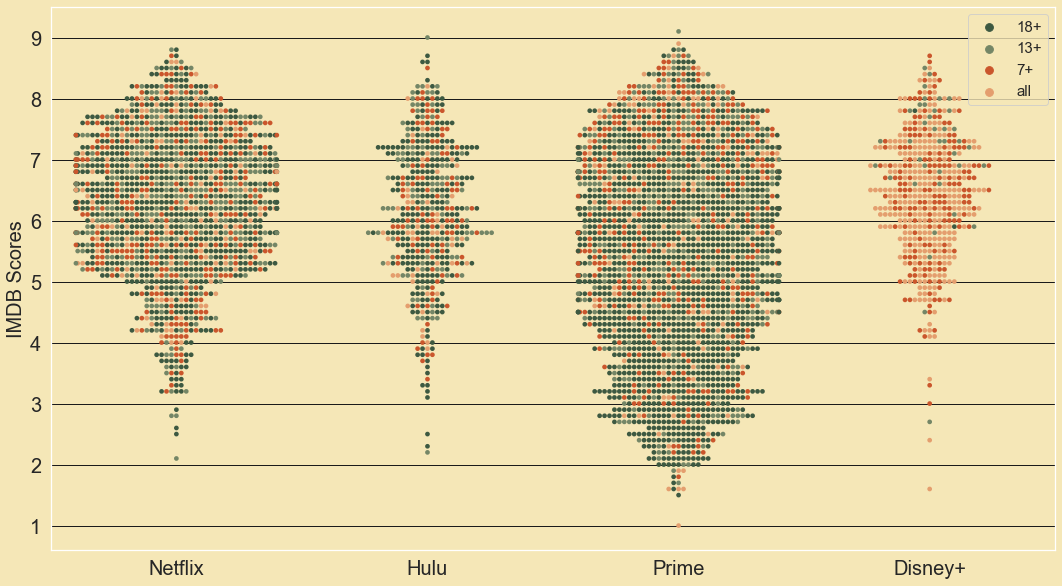

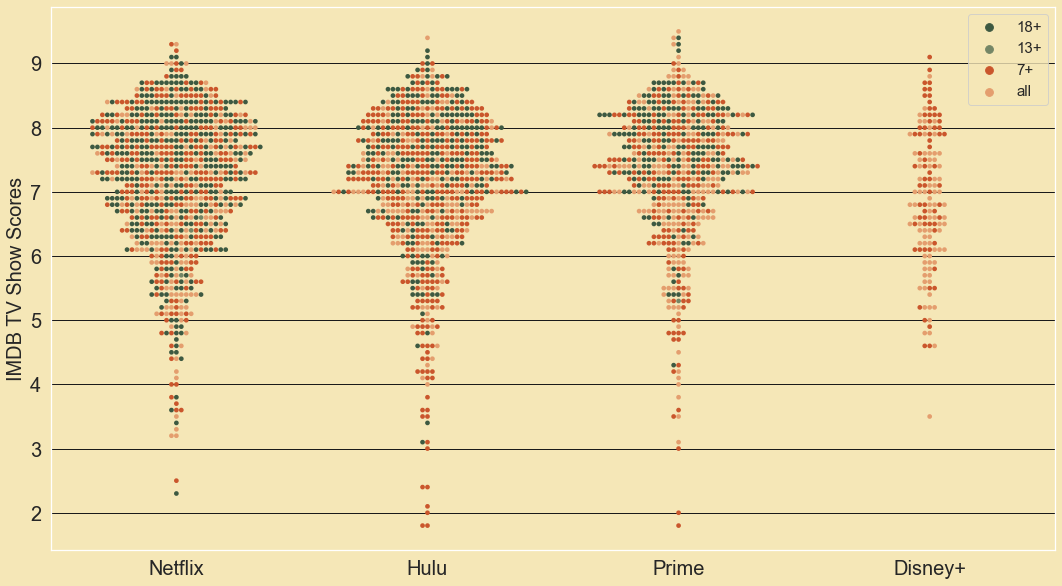

In [41]:
# Movies
NetflixIMDBScores = [float(row[5]) for row in AdjustedMovieData if int(row[7]) == 1 if row[5] if row[4] != "not rated" if row[4] != "16+"]
HuluIMDBScores = [float(row[5]) for row in AdjustedMovieData if int(row[8]) == 1 if row[5] if row[4] != "not rated" if row[4] != "16+"]
PrimeIMDBScores = [float(row[5]) for row in AdjustedMovieData if int(row[9]) == 1 if row[5] if row[4] != "not rated" if row[4] != "16+"]
DisneyIMDBScores = [float(row[5]) for row in AdjustedMovieData if int(row[10]) == 1 if row[5] if row[4] != "not rated" if row[4] != "16+"]

# TV Shows
NetflixIMDBTVshowScores = [float(row[3]) for row in AdjustedTVshowData if row[5] == "True" if row[3] if row[2] != "not rated" if row[2] != "16+"]
HuluIMDBTVshowScores = [float(row[3]) for row in AdjustedTVshowData if row[6] == "True" if row[3] if row[2] != "not rated" if row[2] != "16+"]
PrimeIMDBTVshowScores = [float(row[3]) for row in AdjustedTVshowData if row[7] == "True" if row[3] if row[2] != "not rated" if row[2] != "16+"]
DisneyIMDBTVshowScores = [float(row[3]) for row in AdjustedTVshowData if row[8] == "True" if row[3] if row[2] != "not rated" if row[2] != "16+"]

# Make new age lists which don't include data points that don't have an IMDB score or have an age rating of "not rated"
# Movies
NetflixIMDBAges = [row[4] for row in AdjustedMovieData if int(row[7]) == 1 if row[5] if row[4] != "not rated" if row[4] != "16+"]
HuluIMDBAges = [row[4] for row in AdjustedMovieData if int(row[8]) == 1 if row[5] if row[4] != "not rated" if row[4] != "16+"]
PrimeIMDBAges = [row[4] for row in AdjustedMovieData if int(row[9]) == 1 if row[5] if row[4] != "not rated" if row[4] != "16+"]
DisneyIMDBAges = [row[4] for row in AdjustedMovieData if int(row[10]) == 1 if row[5] if row[4] != "not rated" if row[4] != "16+"]

# TV Shows
NetflixIMDBTVshowAges = [row[2] for row in AdjustedTVshowData if row[5] == "True" if row[3] if row[2] != "not rated" if row[2] != "16+"]
HuluIMDBTVshowAges = [row[2] for row in AdjustedTVshowData if row[6] == "True" if row[3] if row[2] != "not rated" if row[2] != "16+"]
PrimeIMDBTVshowAges = [row[2] for row in AdjustedTVshowData if row[7] == "True" if row[3] if row[2] != "not rated" if row[2] != "16+"]
DisneyIMDBTVshowAges = [row[2] for row in AdjustedTVshowData if row[8] == "True" if row[3] if row[2] != "not rated" if row[2] != "16+"]

# Gather all platform IMDB scores and ages
IMDBMovieScores = [NetflixIMDBScores, HuluIMDBScores, PrimeIMDBScores, DisneyIMDBScores]
IMDBMovieAges = [NetflixIMDBAges, HuluIMDBAges, PrimeIMDBAges, DisneyIMDBAges]
IMDBTVshowScores = [NetflixIMDBTVshowScores, HuluIMDBTVshowScores, PrimeIMDBTVshowScores, DisneyIMDBTVshowScores]
IMDBTVshowAges = [NetflixIMDBTVshowAges, HuluIMDBTVshowAges, PrimeIMDBTVshowAges, DisneyIMDBTVshowAges]

MoviePlotFlag = 4
TVPlotFlag = 4

scatter_plots(IMDBMovieScores, "IMDB Scores", 'IMDBMovieScoresScatterPlot', IMDBMovieAges, "Ages", MoviePlotFlag)
scatter_plots(IMDBTVshowScores, "IMDB TV Show Scores", 'IMDBTVShowScoresScatterPlot.png', IMDBTVshowAges, "Ages", TVPlotFlag)

In [42]:
def scatter_plots(Data1, Data1Name, Filename, Data2=[], Data2Name="", PlotFlag=4):
    '''
    This function makes a scatter plot with the x-values being the different streaming platforms Data1
    is associated with, and the y-values (Data1) being the attribute we want to compare between streaming platforms 
    (e.g. make plot of all IMDB scores of the movies on Netflix, Hulu, Prime, Disney+). 
    Data2 is an optional argument which adds a third dimension to the plot: the colors of the 
    points are tied to another attibute (e.g. point is red if movie is rated 13+, point is blue if movie is rated 18+, etc)
    Note: order of streaming platforms in Data1 and Data2 must be Netflix, Hulu, Prime, Disney+

    :param Data1: List of lists containing data on one attribute of each streaming platform 
    :param Data1Name: Name of attribute in Data1 (e.g. "IMDB Scores")
    :param Filename: Filename of saved scatter plot 
    :param Data2: List of lists containing data on one attribute of each streaming platform 
    :param Data2Name: Name of attribute in Data2 (e.g. "Ages")
    :param PlotFlag: Specifies how many plots to have on one figure. Can take on value 1 or 4.
    :type Data1: List of lists
    :type Data1Name: String
    :type Filename: String
    :type Data2: List of lists
    :type Data2Name: String
    :type PlotFlag: int
    '''
    assert isinstance(Data1, list), "Data1 must be a list"
    assert isinstance(Data2, list), "Data2 must be a list"
    assert isinstance(Filename, str), "Filename must be a string"
    assert isinstance(Data1Name, str), "Data1Name must be a string"
    assert isinstance(Data2Name, str), "Data2Name must be a string"
    assert isinstance(PlotFlag, int), "Data2Name must be a string"
    assert PlotFlag == 1 or PlotFlag == 4, "PlotFlag can only take on values 1 or 4 currently"

    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.set(rc={'figure.figsize':(18, 10)})

    # Create array with colors to use
    Colors = ["#3D5941", "#748666", "#CA562C", "#E49E6E", "#f5e7b7"] # Jake added Colors[-1] because this is the background of the slides
    # Set custom color palette
    sns.set(rc={'axes.facecolor': Colors[4], 'figure.facecolor': Colors[4], "grid.linewidth":1, "grid.color": 'k'})
    sns.set_palette(sns.color_palette(Colors))
    
    if Data2:
        if PlotFlag == 4:
            StreamingPlatform = sum([["Netflix"]*len(Data1[0]), ["Hulu"]*len(Data1[1]), ["Prime"]*len(Data1[2]), ["Disney+"]*len(Data1[3])], [])
            Data1 = sum(Data1, [])
            Data2 = sum(Data2, [])

    # this case is for all four swarm plots to be on the same figure
    if PlotFlag == 4:
        if Data2:
            FinalDataStruct = pd.DataFrame({"Streaming Platform": StreamingPlatform, Data1Name: Data1, Data2Name: Data2})
            plt.figure()
            swarm_plot = sns.swarmplot(x="Streaming Platform", y=Data1Name, hue_order=["18+", "13+", "7+", "all"], hue=Data2Name, data=FinalDataStruct, size=4.7)
            IMDBScatter = swarm_plot.get_figure()
            swarm_plot.set_xlabel("")
            swarm_plot.set_ylabel(Data1Name,fontsize=20)
            swarm_plot.tick_params(labelsize=20)
            plt.legend(fontsize='15', title_fontsize='20')
            IMDBScatter.savefig(Filename+".png") 

In [43]:
colors = ["#546E3D", "#9AFF47", "#E39E63", "#760000", "#9B2700", "#D8EA65", "#9B6900", "#C28500", "#FF950E", "#FF5D1C", "#DFB28A", "#C86A3D", "#CED09F"]
def create_dict(df,platform):
    ''' 
    Creates a dictionary for year wise list of movies and the number of movies for each set of 10 years
    params input: df: input dataframe
    params input: platform: platform for which dictionary is to be created
    params output: returns a dictionary of number of movies for each set of 10 years
    '''
    assert(isinstance(df,pd.DataFrame))
    assert(isinstance(platform,str))
    tvdf = df
    dictyr = {}
    for i in range(len(tvdf.index)):
        if tvdf.iloc[i][platform] == True:
            try:
                dictyr[tvdf.iloc[i]['Year']].append(tvdf.iloc[i]['Title'])
            except:
                dictyr[tvdf.iloc[i]['Year']] = []
                dictyr[tvdf.iloc[i]['Year']].append(tvdf.iloc[i]['Title'])
    dictyrnum = {}
    for keys,values in dictyr.items():
        dictyrnum[keys] = len(values)
    ordereddictyrnum = OrderedDict(sorted(dictyrnum.items(), key=lambda t: t[0]))
    minyrn = list(ordereddictyrnum.keys())[0]
    z =  (minyrn - 1900)//10
    cnt = 1900 + z*10
    cntfil = 0
    dictyrchunksnum = {}
    for keys in ordereddictyrnum.keys():
        try:
            cntfil = (keys-cnt)//10
            dictyrchunksnum[cntfil] = dictyrchunksnum[cntfil] + ordereddictyrnum[keys]
        except:
            cntfil = (keys-cnt)//10
            dictyrchunksnum[cntfil] = 0
            dictyrchunksnum[cntfil] = dictyrchunksnum[cntfil] + ordereddictyrnum[keys]
    i = 1900 + z*10
    newdictyrchunksnumnetflix = {}
    for keys,values in dictyrchunksnum.items():
        newdictyrchunksnumnetflix[str(i)+'-'+str(i+9)] = values
        i = i+10
    return newdictyrchunksnumnetflix

In [44]:
newdictyrchunksnumnetflix = create_dict(tvdf,'Netflix')
newdictyrchunksnumhulu = create_dict(tvdf,'Hulu')
newdictyrchunksnumpv = create_dict(tvdf,'Prime Video')
newdictyrchunksnumdp = create_dict(tvdf,'Disney+')

In [45]:
for k,v in newdictyrchunksnumhulu.items():
    if k in newdictyrchunksnumnetflix.keys():
        continue
    else:
        newdictyrchunksnumnetflix[k] = 0
for k,v in newdictyrchunksnumhulu.items():
    if k in newdictyrchunksnumpv.keys():
        continue
    else:
        newdictyrchunksnumpv[k] = 0
for k,v in newdictyrchunksnumhulu.items():
    if k in newdictyrchunksnumdp.keys():
        continue
    else:
        newdictyrchunksnumdp[k] = 0

In [46]:
yrdict_tv = {}
for k,v in newdictyrchunksnumnetflix.items():
    try:
        yrdict_tv[k]
    except:
        yrdict_tv[k] = {}
    yrdict_tv[k]['Netflix'] = v
for k,v in newdictyrchunksnumhulu.items():
    try:
        yrdict_tv[k]
    except:
        yrdict_tv[k] = {}
    yrdict_tv[k]['Hulu'] = v
for k,v in newdictyrchunksnumpv.items():
    try:
        yrdict_tv[k]
    except:
        yrdict_tv[k] = {}
    yrdict_tv[k]['Prime Video'] = v

for k,v in newdictyrchunksnumdp.items():
    try:
        yrdict_tv[k]
    except:
        yrdict_tv[k] = {}
    yrdict_tv[k]['Disney+'] = v

In [47]:
newdictyrchunksnumnetflix_m = create_dict(moviedf,'Netflix')
newdictyrchunksnumhulu_m = create_dict(moviedf,'Hulu')
newdictyrchunksnumpv_m = create_dict(moviedf,'Prime Video')
newdictyrchunksnumdp_m = create_dict(moviedf,'Disney+')

In [48]:
for k,v in newdictyrchunksnumpv_m.items():
    if k in newdictyrchunksnumnetflix_m.keys():
        continue
    else:
        newdictyrchunksnumnetflix_m[k] = 0
for k,v in newdictyrchunksnumpv_m.items():
    if k in newdictyrchunksnumhulu_m.keys():
        continue
    else:
        newdictyrchunksnumhulu_m[k] = 0
for k,v in newdictyrchunksnumpv_m.items():
    if k in newdictyrchunksnumdp_m.keys():
        continue
    else:
        newdictyrchunksnumdp_m[k] = 0

In [49]:
yrdict_m = {}
for k,v in newdictyrchunksnumnetflix_m.items():
    try:
        yrdict_m[k]
    except:
        yrdict_m[k] = {}
    yrdict_m[k]['Netflix'] = v
for k,v in newdictyrchunksnumhulu_m.items():
    try:
        yrdict_m[k]
    except:
        yrdict_m[k] = {}
    yrdict_m[k]['Hulu'] = v
for k,v in newdictyrchunksnumpv_m.items():
    try:
        yrdict_m[k]
    except:
        yrdict_m[k] = {}
    yrdict_m[k]['Prime Video'] = v
for k,v in newdictyrchunksnumdp_m.items():
    try:
        yrdict_m[k]
    except:
        yrdict_m[k] = {}
    yrdict_m[k]['Disney+'] = v

<ipython-input-50-301b0523c221>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax2 = plt.axes()


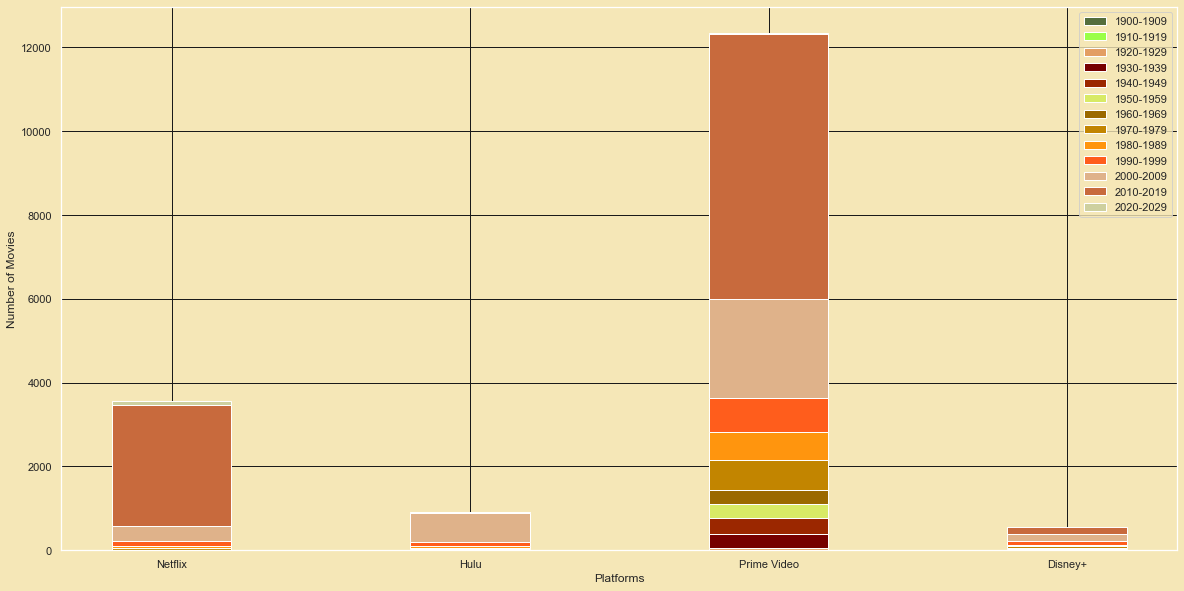

In [50]:
'''
Uses a dictionary of dictionaries to take year wise data of number of movies on each platform Netflix, Hulu, Prime Video 
and Disney+ and plots a stacked bar chart for representation
yrdict_m: dictionary of dictionaries of year wise distribution of platforms and number of movies
'''
assert(isinstance(yrdict_m,dict))
for k,v in yrdict_m.items():
    assert(isinstance(v,dict))
plt.figure(figsize=(20,10))
plt.bar(yrdict_m['1900-1909'].keys(), yrdict_m['1900-1909'].values(), width=0.4, align='center', label='1900-1909', color=colors[0])
plt.bar(yrdict_m['1910-1919'].keys(), yrdict_m['1910-1919'].values(), bottom=[yrdict_m['1900-1909'][i] for i in yrdict_m['1910-1919'].keys()], width=0.4, align='center', label='1910-1919', color=colors[1])
plt.bar(yrdict_m['1920-1929'].keys(), yrdict_m['1920-1929'].values(), bottom=[yrdict_m['1900-1909'][i]+yrdict_m['1910-1919'][i] for i in yrdict_m['1920-1929'].keys()], width=0.4, align='center', label='1920-1929',color  = colors[2])
plt.bar(yrdict_m['1930-1939'].keys(), yrdict_m['1930-1939'].values(), bottom=[yrdict_m['1900-1909'][i]+yrdict_m['1910-1919'][i]+yrdict_m['1920-1929'][i] for i in yrdict_m['1930-1939'].keys()], width=0.4, align='center', label='1930-1939', color = colors[3])
plt.bar(yrdict_m['1940-1949'].keys(), yrdict_m['1940-1949'].values(), bottom=[yrdict_m['1900-1909'][i]+yrdict_m['1910-1919'][i]+yrdict_m['1920-1929'][i]+yrdict_m['1930-1939'][i] for i in yrdict_m['1940-1949'].keys()], width=0.4, align='center', label='1940-1949',color = colors[4])
plt.bar(yrdict_m['1950-1959'].keys(), yrdict_m['1950-1959'].values(), bottom=[yrdict_m['1900-1909'][i]+yrdict_m['1910-1919'][i]+yrdict_m['1920-1929'][i]+yrdict_m['1930-1939'][i]+yrdict_m['1940-1949'][i] for i in yrdict_m['1950-1959'].keys()], width=0.4, align='center', label='1950-1959', color = colors[5])
plt.bar(yrdict_m['1960-1969'].keys(), yrdict_m['1960-1969'].values(), bottom=[yrdict_m['1900-1909'][i]+yrdict_m['1910-1919'][i]+yrdict_m['1920-1929'][i]+yrdict_m['1930-1939'][i]+yrdict_m['1940-1949'][i]+yrdict_m['1950-1959'][i] for i in yrdict_m['1960-1969'].keys()], width=0.4, align='center', label='1960-1969', color = colors[6])
plt.bar(yrdict_m['1970-1979'].keys(), yrdict_m['1970-1979'].values(), bottom=[yrdict_m['1900-1909'][i]+yrdict_m['1910-1919'][i]+yrdict_m['1920-1929'][i]+yrdict_m['1930-1939'][i]+yrdict_m['1940-1949'][i]+yrdict_m['1950-1959'][i]+yrdict_m['1960-1969'][i] for i in yrdict_m['1970-1979'].keys()], width=0.4, align='center', label='1970-1979', color = colors[7])
plt.bar(yrdict_m['1980-1989'].keys(), yrdict_m['1980-1989'].values(), bottom=[yrdict_m['1900-1909'][i]+yrdict_m['1910-1919'][i]+yrdict_m['1920-1929'][i]+yrdict_m['1930-1939'][i]+yrdict_m['1940-1949'][i]+yrdict_m['1950-1959'][i]+yrdict_m['1960-1969'][i]+yrdict_m['1970-1979'][i] for i in yrdict_m['1980-1989'].keys()], width=0.4, align='center', label='1980-1989', color = colors[8])
plt.bar(yrdict_m['1990-1999'].keys(), yrdict_m['1990-1999'].values(), bottom=[yrdict_m['1900-1909'][i]+yrdict_m['1910-1919'][i]+yrdict_m['1920-1929'][i]+yrdict_m['1930-1939'][i]+yrdict_m['1940-1949'][i]+yrdict_m['1950-1959'][i]+yrdict_m['1960-1969'][i]+yrdict_m['1970-1979'][i]+yrdict_m['1980-1989'][i] for i in yrdict_m['1990-1999'].keys()], width=0.4, align='center', label='1990-1999', color = colors[9])
plt.bar(yrdict_m['2000-2009'].keys(), yrdict_m['2000-2009'].values(), bottom=[yrdict_m['1900-1909'][i]+yrdict_m['1910-1919'][i]+yrdict_m['1920-1929'][i]+yrdict_m['1930-1939'][i]+yrdict_m['1940-1949'][i]+yrdict_m['1950-1959'][i]+yrdict_m['1960-1969'][i]+yrdict_m['1970-1979'][i]+yrdict_m['1980-1989'][i]+yrdict_m['1990-1999'][i] for i in yrdict_m['2000-2009'].keys()], width=0.4, align='center', label='2000-2009', color = colors[10])
plt.bar(yrdict_m['2010-2019'].keys(), yrdict_m['2010-2019'].values(), bottom=[yrdict_m['1900-1909'][i]+yrdict_m['1910-1919'][i]+yrdict_m['1920-1929'][i]+yrdict_m['1930-1939'][i]+yrdict_m['1940-1949'][i]+yrdict_m['1950-1959'][i]+yrdict_m['1960-1969'][i]+yrdict_m['1970-1979'][i]+yrdict_m['1980-1989'][i]+yrdict_m['1990-1999'][i]+yrdict_m['2000-2009'][i] for i in yrdict_m['2010-2019'].keys()], width=0.4, align='center', label='2010-2019', color = colors[11])
plt.bar(yrdict_m['2020-2029'].keys(), yrdict_m['2020-2029'].values(), bottom=[yrdict_m['1900-1909'][i]+yrdict_m['1910-1919'][i]+yrdict_m['1920-1929'][i]+yrdict_m['1930-1939'][i]+yrdict_m['1940-1949'][i]+yrdict_m['1950-1959'][i]+yrdict_m['1960-1969'][i]+yrdict_m['1970-1979'][i]+yrdict_m['1980-1989'][i]+yrdict_m['1990-1999'][i]+yrdict_m['2000-2009'][i]+yrdict_m['2010-2019'][i] for i in yrdict_m['2020-2029'].keys()], width=0.4, align='center', label='2020-2029', color = colors[12])
plt.xlabel('Platforms')
plt.ylabel('Number of Movies')
ax2 = plt.axes() 
ax2.set_facecolor("#f5e7b7") 
SMALL_SIZE = 20
plt.rcParams['figure.facecolor'] = '#f5e7b7'
plt.rc('font', size=SMALL_SIZE) 
plt.rc('axes', titlesize=SMALL_SIZE)  
plt.legend()

<ipython-input-51-48934e7807aa>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.axes()


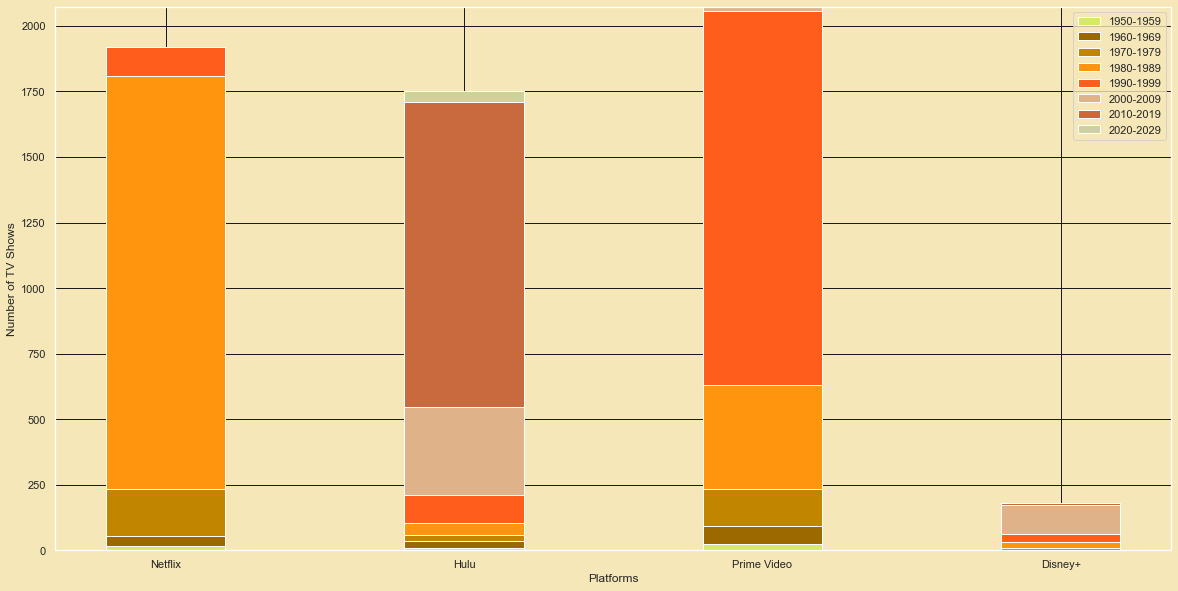

In [51]:
'''
Uses a dictionary of dictionaries to take year wise data of number of TV Shows on each platform Netflix, Hulu, Prime Video 
and Disney+ and plots a stacked bar chart for representation
yrdict_tv: dictionary of dictionaries of year wise distribution of platforms and number of TV Shows
'''
assert(isinstance(yrdict_tv,dict))
for k,v in yrdict_m.items():
    assert(isinstance(v,dict))
plt.figure(figsize=(20,10))
plt.bar(yrdict_tv['1950-1959'].keys(), yrdict_tv['1950-1959'].values(), width=0.4, align='center', label='1950-1959', color=colors[5])
plt.bar(yrdict_tv['1960-1969'].keys(), yrdict_tv['1960-1969'].values(), bottom=[yrdict_tv['1950-1959'][i] for i in yrdict_tv['1960-1969'].keys()], width=0.4, align='center', label='1960-1969', color = colors[6])
plt.bar(yrdict_tv['1970-1979'].keys(), yrdict_tv['1970-1979'].values(), bottom=[yrdict_tv['1950-1959'][i]+yrdict_tv['1960-1969'][i] for i in yrdict_tv['1970-1979'].keys()], width=0.4, align='center', label='1970-1979', color = colors[7])
plt.bar(yrdict_tv['1980-1989'].keys(), yrdict_tv['1980-1989'].values(), bottom=[yrdict_tv['1950-1959'][i]+yrdict_tv['1960-1969'][i]+yrdict_tv['1970-1979'][i] for i in yrdict_tv['1980-1989'].keys()], width=0.4, align='center', label='1980-1989', color = colors[8])
plt.bar(yrdict_tv['1990-1999'].keys(), yrdict_tv['1990-1999'].values(), bottom=[yrdict_tv['1950-1959'][i]+yrdict_tv['1960-1969'][i]+yrdict_tv['1970-1979'][i]+yrdict_tv['1980-1989'][i] for i in yrdict_tv['1990-1999'].keys()], width=0.4, align='center', label='1990-1999', color = colors[9])
plt.bar(yrdict_tv['2000-2009'].keys(), yrdict_tv['2000-2009'].values(), bottom=[yrdict_tv['1950-1959'][i]+yrdict_tv['1960-1969'][i]+yrdict_tv['1970-1979'][i]+yrdict_tv['1980-1989'][i]+yrdict_tv['1990-1999'][i] for i in yrdict_tv['2000-2009'].keys()], width=0.4, align='center', label='2000-2009', color = colors[10])
plt.bar(yrdict_tv['2010-2019'].keys(), yrdict_tv['2010-2019'].values(), bottom=[yrdict_tv['1950-1959'][i]+yrdict_tv['1960-1969'][i]+yrdict_tv['1970-1979'][i]+yrdict_tv['1980-1989'][i]+yrdict_tv['1990-1999'][i]+yrdict_tv['2000-2009'][i] for i in yrdict_tv['2010-2019'].keys()], width=0.4, align='center', label='2010-2019', color = colors[11])
plt.bar(yrdict_tv['2020-2029'].keys(), yrdict_tv['2020-2029'].values(), bottom=[yrdict_tv['1950-1959'][i]+yrdict_tv['1960-1969'][i]+yrdict_tv['1970-1979'][i]+yrdict_tv['1980-1989'][i]+yrdict_tv['1990-1999'][i]+yrdict_tv['2000-2009'][i]+yrdict_tv['2010-2019'][i] for i in yrdict_tv['2020-2029'].keys()], width=0.4, align='center', label='2020-2029', color = colors[12])
plt.xlabel('Platforms')
plt.ylabel('Number of TV Shows')
SMALL_SIZE = 20
ax1 = plt.axes() 
ax1.set_facecolor("#f5e7b7") 
plt.rcParams['figure.facecolor'] = '#f5e7b7'
plt.rc('font', size=SMALL_SIZE)          
plt.rc('axes', titlesize=SMALL_SIZE)  
plt.rcParams['axes.facecolor']='#f5e7b7'
plt.legend()

In [52]:
def red_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    '''
    Plotting wordcloud font as red
    '''
    assert(isinstance(word,str))
    return "hsl(0, 100%%, %d%%)" % random.randint(30, 50)

def green_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    '''
    Plotting wordcloud font as green
    '''
    assert(isinstance(word,str))
    return "hsl(100, 100%%, %d%%)" % random.randint(20, 40)
def blue_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    '''
    Plotting wordcloud font as blue
    '''
    assert(isinstance(word,str))
    return "hsl(190, 100%%, %d%%)" % random.randint(40, 60)
def purple_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    '''
    Plotting wordcloud font as purple
    '''
    assert(isinstance(word,str))
    return "hsl(300, 47%%, %d%%)" % random.randint(60, 80)

In [53]:
def create_Wordcloud(df,platform,color):
    '''
    Takes the dataframe, the platform and the color function as the input and plots the wordcloud
    param input: df: input dataframe
    param input: platform: input platform 
    param input: color: color function 
    '''
    assert(isinstance(df,pd.DataFrame))
    assert(isinstance(platform,str))
    assert(isinstance(color,str))
    imdbdf = df
    directors = ''
    dictyr = {}
    imdbdf = imdbdf.dropna()
    listdirectors = []
    for i in range(len(imdbdf.index)):
        movie  = imdbdf.iloc[i]['Title']
        valdf = (moviedf.loc[moviedf['Title'] == movie])
        if valdf.empty:
            continue
        jval = (valdf[platform].values[0])
        if jval == 1:
            directors = imdbdf.iloc[i]['Description']
            listdirectors.append(directors.split(','))
    mergedlist = list(itertools.chain.from_iterable(listdirectors))
    unique_string=(" ").join(mergedlist)
    wordcloud = WordCloud(width = 1000, height = 500, background_color='#f5e7b7').generate(unique_string)
    if color == 'red':
        func = red_func
    if color == 'green':
        func = green_func
    if color == 'blue':
        func = blue_func
    if color == 'purple':
        func = purple_func
    plt.imshow(wordcloud.recolor(color_func=func))
    plt.axis("off")
    plt.savefig("wordc1_net_mov_d"+".png", bbox_inches='tight')
    plt.show()
    plt.close()

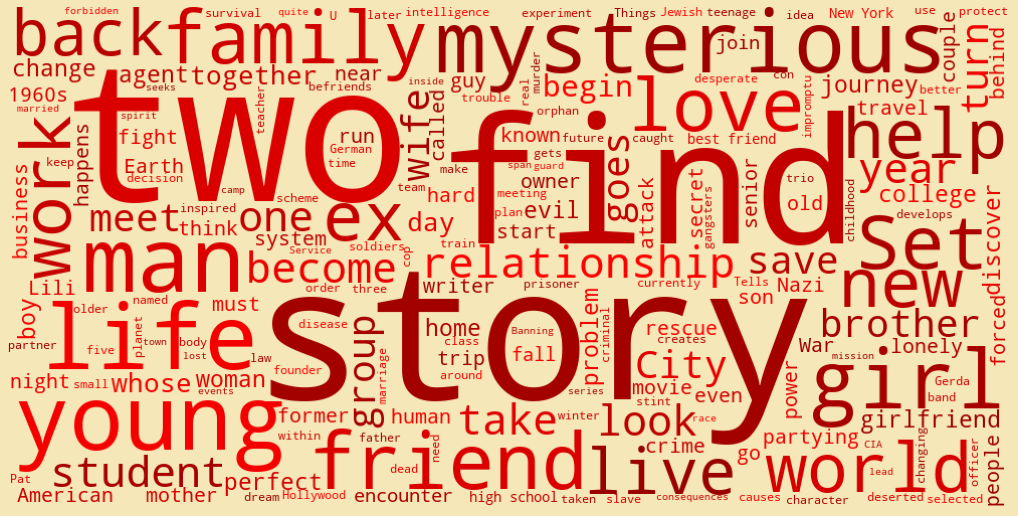

In [54]:
create_Wordcloud(imdbdf,'Netflix','red')

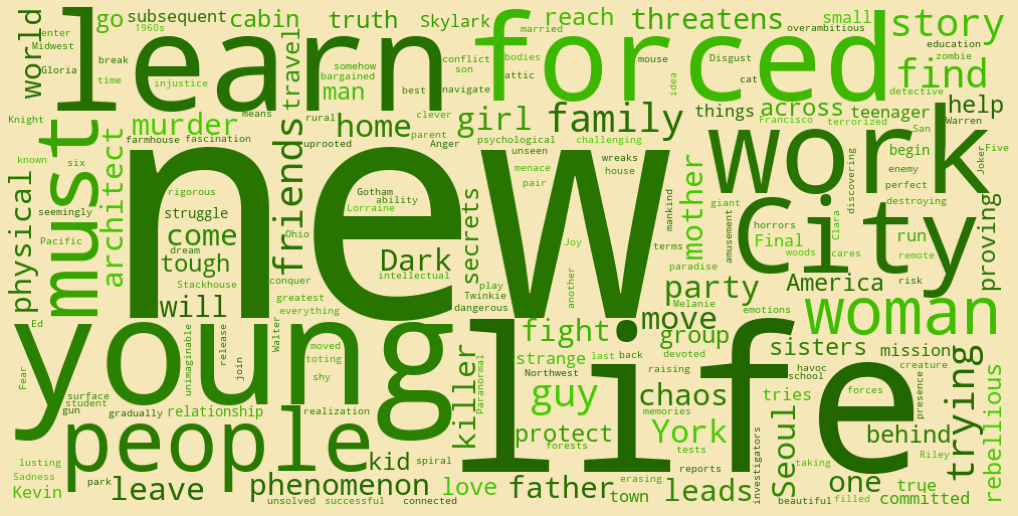

In [55]:
create_Wordcloud(imdbdf,'Hulu','green')

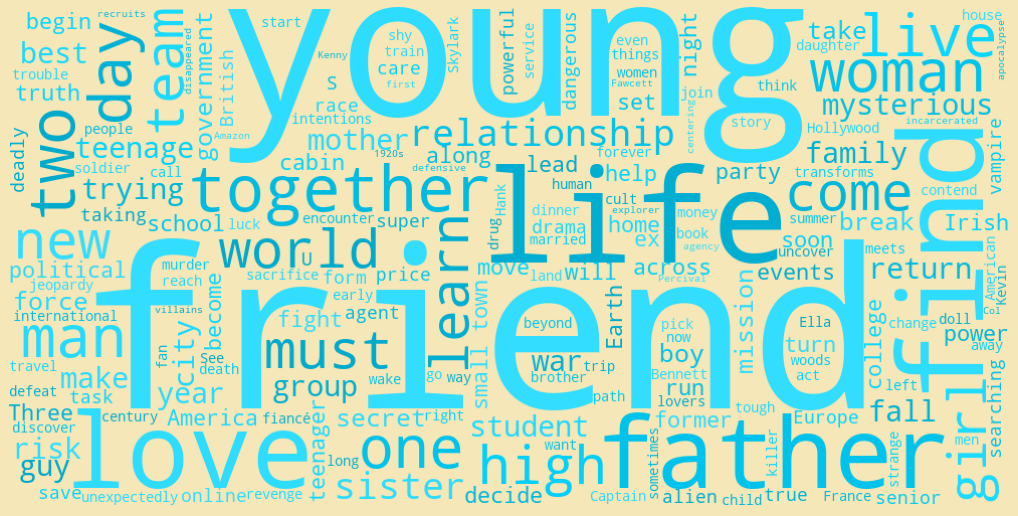

In [56]:
create_Wordcloud(imdbdf,'Prime Video','blue')

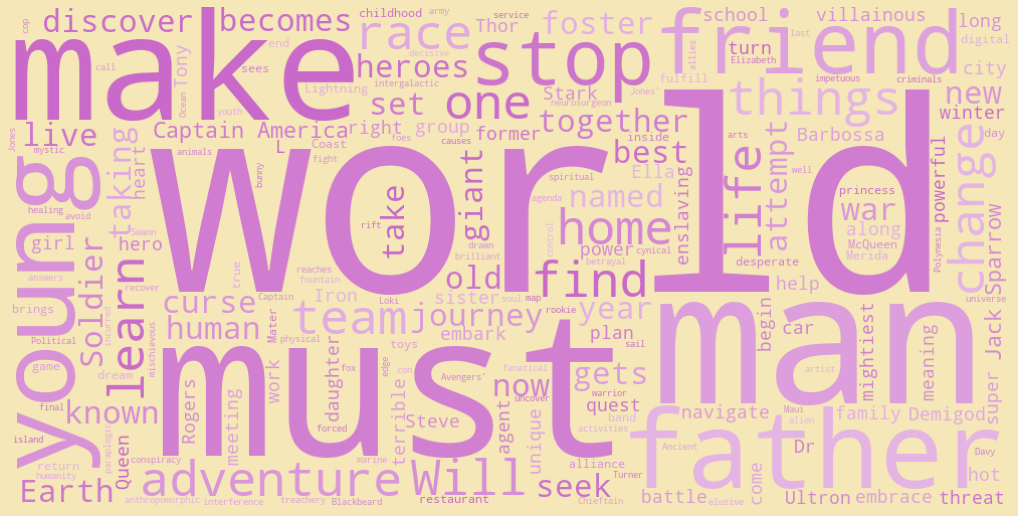

In [57]:
create_Wordcloud(imdbdf,'Disney+','purple')